In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
from tqdm import tqdm



In [143]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

In [144]:
# Set device (either CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [145]:
# Define the labels and paths
labels = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]
data_csv = "ChestX-ray14/Filtered_Cases_with_One_or_No_Finding.csv"
base_dir = "/Users/zafercalisir/Desktop/GradProj/cnn-in-nih14/dataset/images-224/images-224"

# Load the CSV file
df = pd.read_csv(data_csv)

# Preview the CSV data
df.head()


,Unnamed: 0.1,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,0,97982,00025849_026.png,Infiltration,26,25849,58,M,AP,3056,2544,0.139,0.139,NaN
1,1,103746,00027697_013.png,Effusion,13,27697,24,F,PA,2544,3056,0.139,0.139,NaN
2,2,89783,00022290_020.png,Effusion,20,22290,58,M,AP,3056,2544,0.139,0.139,NaN
3,4,89420,00022196_002.png,No Finding,2,22196,51,F,PA,2566,2893,0.143,0.143,NaN
4,6,60955,00015042_005.png,No Finding,5,15042,44,M,AP,2500,2048,0.168,0.168,NaN


In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example labels (replace with your actual class names)
labels = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]


def multi_hot_encoding(label_str):
    return [1 if label in label_str.split("|") else 0 for label in labels]

# Assuming df is your DataFrame containing the images and labels
df['labels'] = df['Finding Labels'].apply(multi_hot_encoding)
# Check the total size of the dataset

print(f"Total dataset size: {len(df)}")

# If dataset is too small (for example, less than 3 samples), handle splits manually
if len(df) < 5:
    print("Dataset is too small. Manually handling splits.")
    train_df = df[:1]  # Use the first sample as training data
    valid_df = df[1:2]  # Use the second sample as validation data
    test_df = df[2:]  # Use the remaining as test data
else:
    # Split the data into training and validation sets (80% train, 20% validation)
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    
    
    # If the validation set is too small, use the remaining data as test
    if len(valid_df) > 1:
        # Split the validation set into test and validation sets (50% test, 50% validation)
        valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
    else:
        # If validation set is too small, use it as the test set
        test_df = valid_df

# Display the label column of a sample row
print(f"Size of validation set: {len(test_df)}")
print(f"Size of validation set: {len(valid_df)}")
train_df.head()


Total dataset size: 18573
Size of validation set: 1858
Size of validation set: 1857


,Unnamed: 0.1,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,labels
18166,29341,54180,00013625_017.png,Infiltration,17,13625,63,M,PA,2992,2991,0.143000,0.143000,NaN,"[1, 0, 0, 0, 0, 0]"
8390,13664,34617,00009118_000.png,Atelectasis,0,9118,46,F,PA,2500,2048,0.168000,0.168000,NaN,"[0, 1, 0, 0, 0, 0]"
5853,9524,3506,00000949_002.png,No Finding,2,949,60,M,AP,2500,2048,0.171000,0.171000,NaN,"[0, 0, 0, 0, 0, 1]"
13600,22076,82926,00020393_006.png,Nodule,6,20393,43,M,AP,3056,2544,0.139000,0.139000,NaN,"[0, 0, 0, 1, 0, 0]"
3421,5544,2637,00000697_002.png,Atelectasis,2,697,65,M,PA,2021,2021,0.194311,0.194311,NaN,"[0, 1, 0, 0, 0, 0]"


In [147]:
# Enable MPS fallback to CPU for unsupported operations
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


In [148]:
print(os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]) 

1


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

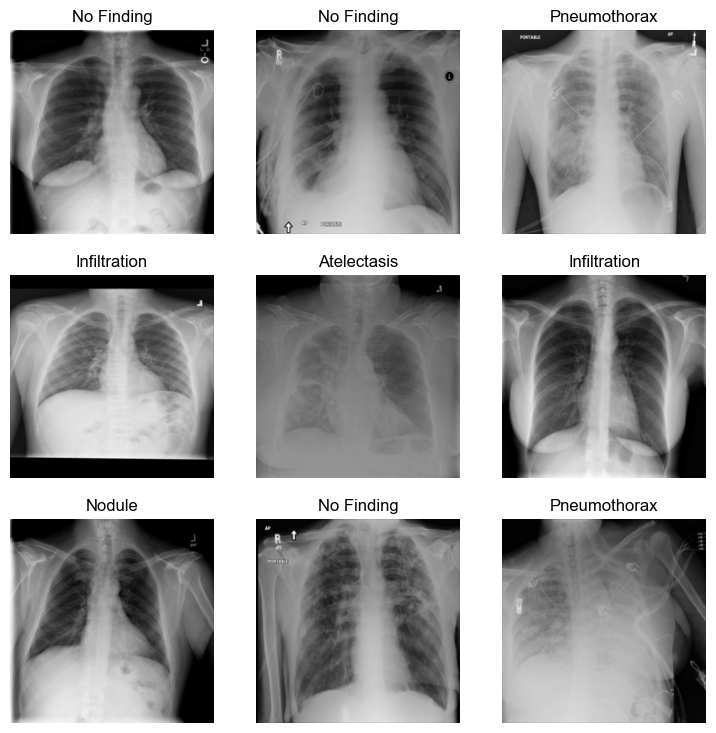

In [149]:
# List of class names (assuming these are the possible findings)
labels = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]

# Update parent_label function to return finding names as a list
def parent_label(item):
    img_name = os.path.basename(item)  # Get image name from the item (path)
    # Find the corresponding labels in the dataframe
    label_str = df[df['Image Index'] == img_name]['Finding Labels'].values[0]
    # Create a list of the finding names (no multi-hot encoding, just the finding names)
    finding_names = [label for label in labels if label in label_str.split("|")]
    return finding_names

# Split the dataframe into training, validation, and test sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

# Define the device (use 'cuda' if you have a GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get filtered image files from the train_df, valid_df, or test_df
def get_filtered_image_files(df_split):
    # Extract image paths from the DataFrame
    return [os.path.join(base_dir, f'{img_name}') for img_name in df_split['Image Index']]

# Create DataBlock for multi-label classification with finding names as labels
dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  # MultiCategoryBlock for multi-label classification
    get_items=get_filtered_image_files,  # Get filtered images from the DataFrame
    get_y=parent_label,  # Get finding names for each image
    item_tfms=[Resize(224)],  # Resize images
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]  # Normalize using imagenet stats (or your own)
)

# Create DataLoaders (use the filtered images and labels)
dls = dls.dataloaders(train_df, valid_df=valid_df, bs=32)

# Move DataLoaders to the correct device
dls = dls.to(device)

# Show a batch of images and labels to check the results
dls.train.show_batch(max_n=9)

# Create the learner
learn = vision_learner(dls, resnet34, metrics=[accuracy_multi])

# Summary of the model
learn.summary()

In [150]:
# Train the model
learn.fine_tune(4)  # Fine-tune the model for 4 epochs

# Optionally, you can monitor the learning rate and apply learning rate annealing
# If needed, you can add callbacks such as ReduceLROnPlateau
# Save the entire learner (model, DataLoaders, optimizer, etc.)
learn.save('model.pth.tar')  # This will save the model with the name 'model.pth.tar'



epoch,train_loss,valid_loss,accuracy_multi,time
0,0.515414,0.441613,0.829519,20:41


epoch,train_loss,valid_loss,accuracy_multi,time


KeyboardInterrupt: 

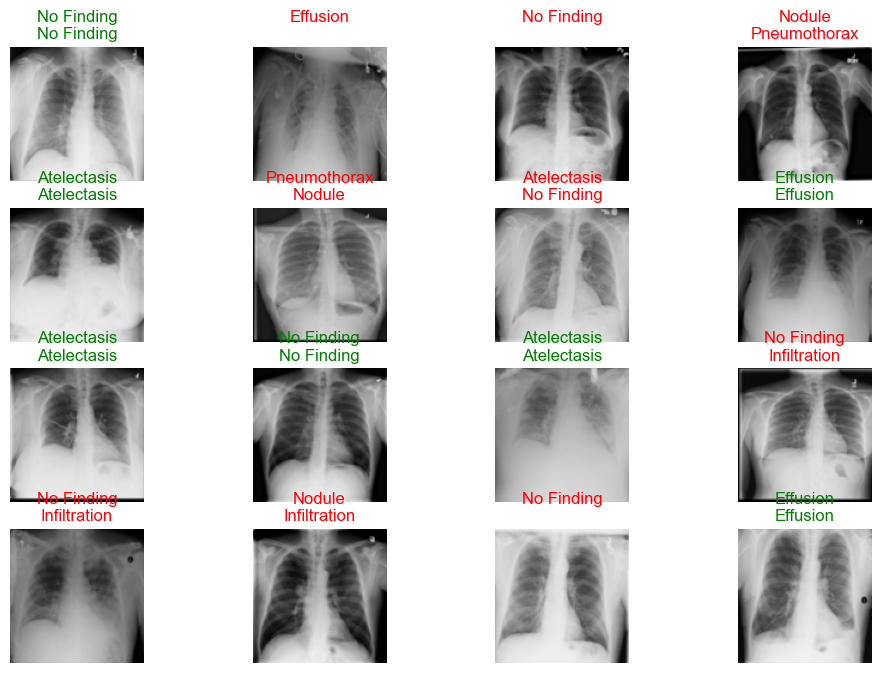

In [ ]:
# Evaluate the model
learn.show_results(max_n=16, figsize=(12,8))


In [ ]:
# Get predictions and targets
preds, targs = learn.get_preds()

# Apply sigmoid to the predictions to convert them into probabilities



In [ ]:
probs = preds.sigmoid()
print(f"Diagnosis: {preds}.")
print(f"The probability of Normal is: {probs[0][0].item():.4f}")


Diagnosis: tensor([[2.7585e-03, 2.5540e-03, 1.2042e-02, 9.7141e-01, 1.2976e-02, 2.1239e-04],
        [6.1255e-02, 1.9471e-01, 2.7449e-01, 1.4914e-01, 1.7608e-02, 5.4142e-02],
        [2.5020e-01, 4.1688e-01, 1.9466e-02, 3.1368e-02, 3.5551e-02, 1.8232e-01],
        ...,
        [1.0899e-01, 1.9569e-01, 8.8796e-03, 2.4508e-02, 7.8317e-01, 1.9667e-02],
        [1.2050e-01, 1.3608e-02, 8.1716e-02, 7.0404e-01, 5.7120e-02, 3.2810e-02],
        [6.0108e-03, 3.9837e-03, 5.3176e-02, 8.9134e-01, 1.4313e-01, 4.6186e-03]]).
The probability of Normal is: 0.5007


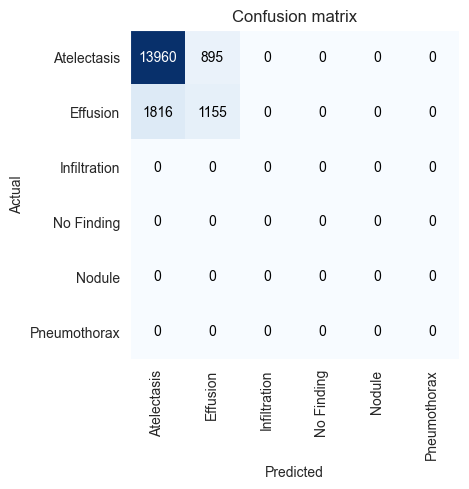

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()


In [ ]:
from sklearn.metrics import roc_auc_score
import torch

# Make predictions on the validation set
preds, targs = learn.get_preds(dl=dls.valid)

# Convert predictions to probabilities using sigmoid (for multi-label classification)
probs = preds.sigmoid()

# Compute AUROC for each label
auroc_scores = []
for i in range(probs.shape[1]):  # Loop through each label
    try:
        # Calculate AUROC for each class, comparing true labels (targs) with predicted probabilities (probs)
        auroc = roc_auc_score(targs[:, i], probs[:, i])  
        auroc_scores.append(auroc)
    except ValueError:
        # Skip if there is only one class in the true labels (this will happen for some labels)
        print(f"Skipping class {i} due to only one class present in the true labels.")

# Print the AUROC for each class
for i, auroc in enumerate(auroc_scores):
    print(f"AUROC for class {labels[i]}: {auroc:.4f}")

# Print average AUROC
average_auroc = sum(auroc_scores) / len(auroc_scores) if auroc_scores else 0
print(f"Average AUROC: {average_auroc:.4f}")


AUROC for class Infiltration: 0.7583
AUROC for class Atelectasis: 0.8199
AUROC for class Effusion: 0.7382
AUROC for class Nodule: 0.7380
AUROC for class Pneumothorax: 0.7534
AUROC for class No Finding: 0.8385
Average AUROC: 0.7744
